In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

DOMAIN = 'drink'

db_dict = {
    'test':   'postgres:///babble_model_unittest',
    'spouse': 'postgres:///babble_model_spouse',
    'bike':   'postgres:///babble_model_bike',
    'drink':  'postgres:///babble_model_drink',
    'cdr':    'postgres:///babble_model_cdr',
}
os.environ['SNORKELDB'] = db_dict[DOMAIN]

In [3]:
from snorkel import SnorkelSession
session = SnorkelSession()

In [4]:
from snorkel.contrib.babble.pipelines import config

config = configuration
config['domain'] = DOMAIN
config['splits'] = [0,1]
config['babbler_split'] = 0
config['max_docs'] = None
config['parallelism'] = 1
config['traditional'] = False
config['majority'] = False
config['verbose'] = True
config['display_marginals'] = True
config['display_accuracies'] = True
config['display_learned_accuracies'] = True

In [5]:
from snorkel.models import candidate_subclass
from tutorials.babble import MTurkHelper
from snorkel.contrib.babble import ExplanationIO

if DOMAIN == 'spouse':
    from tutorials.babble.spouse import SpousePipeline
    Spouse = candidate_subclass('Spouse', ['person1', 'person2'])
    candidate_class = Spouse
    
    expio = ExplanationIO()
    fpath = (os.environ['SNORKELHOME'] + 
        '/tutorials/babble/spouse/data/mturk_explanations_all.tsv')
    explanations = expio.read(fpath)
    
    sm = SpousePipeline(session, Spouse, config)
elif DOMAIN == 'bike':
    from tutorials.babble.bike import BikePipeline
    Biker = candidate_subclass('Biker', ['person', 'bike'])
    candidate_class = Biker
    
    helper = MTurkHelper()
    output_csv_path = (os.environ['SNORKELHOME'] + 
                       '/tutorials/babble/bike/data/VisualGenome_all_out.csv')
    explanations = helper.postprocess_visual(output_csv_path, set_name='train', verbose=False)
    
    sm = BikePipeline(session, Biker, config)
elif DOMAIN == 'drink':
    from tutorials.babble.drink import DrinkPipeline
    Drinker = candidate_subclass('Drinker', ['person', 'cup'])
    candidate_class = Drinker
    
    helper = MTurkHelper()
    output_csv_path = (os.environ['SNORKELHOME'] + 
                       '/tutorials/babble/drink/data/Reach_Explanation_out.csv')
    explanations = helper.postprocess_visual(output_csv_path, set_name='train', verbose=False)
    
    sm = DrinkPipeline(session, Drinker, config)   
else:
    raise Exception('Invalid domain: {}'.format(DOMAIN))
user_lists = {}
print("Total explanations: {}".format(len(explanations)))

Reading train CSV!
Num HITs unique: 44
Num HITs total: 132
Unanimous: 112
Majority: 54
Bad: 37
Total explanations: 370


In [6]:
anns_folder = os.environ['SNORKELHOME'] + '/tutorials/babble/drink/data/'
%time sm.parse(anns_folder)

Clearing existing...
Running UDF...
Running UDF...
CPU times: user 10.6 s, sys: 868 ms, total: 11.4 s
Wall time: 29.6 s


In [7]:
%time sm.extract()

Extraction was performed during parse stage.
Candidates [Split 0]: 2524
Candidates [Split 1]: 495
CPU times: user 24 ms, sys: 16 ms, total: 40 ms
Wall time: 29.1 ms


In [8]:
%time sm.load_gold(anns_folder)

Reading val CSV!
Num HITs unique: 124
Num HITs total: 248
Unanimous: 279
Majority: 263
Bad: 84
Reading train CSV!
Num HITs unique: 631
Num HITs total: 1262
Unanimous: 1560
Majority: 1374
Bad: 277
AnnotatorLabels created: 411
AnnotatorLabels created: 2247
CPU times: user 36.6 s, sys: 992 ms, total: 37.6 s
Wall time: 46.9 s


In [9]:
from snorkel.annotations import load_gold_labels
L_gold_train = load_gold_labels(session, annotator_name='gold', split=0)
L_gold_train

<2524x1 sparse matrix of type '<type 'numpy.int64'>'
	with 2247 stored elements in Compressed Sparse Row format>

In [10]:
import numpy as np
np.shape(np.where(np.array(L_gold_train.todense()) == 1))[1]

757

In [11]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev

<495x1 sparse matrix of type '<type 'numpy.int64'>'
	with 411 stored elements in Compressed Sparse Row format>

In [12]:
import numpy as np
np.shape(np.where(np.array(L_gold_dev.todense()) == 1))[1]

145

In [13]:
candidates = session.query(candidate_class).filter(
    candidate_class.split == config['babbler_split']).all()
# candidates = session.query(candidate_class).filter(candidate_class.split == 0).all()
print(len(candidates))

2524


In [14]:
from snorkel.contrib.babble import link_explanation_candidates

explanations = link_explanation_candidates(explanations, candidates)

Building list of target candidate ids...
Collected 139 unique target candidate ids from 370 explanations.
Gathering desired candidates...
Found 139/139 desired candidates
Linking explanations to candidates...
Linked 370/370 explanations


In [15]:
%time sm.babble(explanations, user_lists=user_lists, config=config)

Calling babbler...
Created grammar with 430 rules
159 parses created from 111 out of 370 explanation(s)
Parsed 159 LFs from 370 explanations.
Filtered to 38 LFs with duplicate semantics filter (121 filtered).
Filtered to 21 LFs with consistency filter (17 filtered).
Clearing existing...
Running UDF...
[========================================] 100%

Filtered to 18 LFs with uniform signatures filter (3 filtered).
Filtered to 14 LFs with duplicate signatures filter (4 filtered).
CPU times: user 42.6 s, sys: 1.68 s, total: 44.3 s
Wall time: 1min 7s


In [16]:
%time sm.label()
import time
time.sleep(10)

Clearing existing...
Running UDF...
[========================================] 100%


Labeled split 0: (2524,14) sparse (nnz = 15831)
Clearing existing...
Running UDF...
[========================================] 100%


Labeled split 1: (495,14) sparse (nnz = 3192)
CPU times: user 39.6 s, sys: 1.25 s, total: 40.8 s
Wall time: 58.7 s


Inferred cardinality: 2


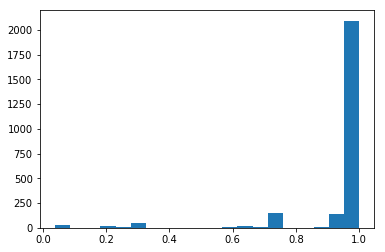

CPU times: user 18.4 s, sys: 5.12 s, total: 23.6 s
Wall time: 18.2 s


In [17]:
%time sm.supervise(config=config)
time.sleep(10)

In [18]:
L_dev = sm.labeler.load_matrix(session, split=1)
time.sleep(10)
L_dev

<495x14 sparse matrix of type '<type 'numpy.int64'>'
	with 3192 stored elements in Compressed Sparse Row format>

In [19]:
L_dev.lf_stats(session, L_gold_dev)
time.sleep(10)

In [37]:
tp, fp, tn, fn = sm.gen_model.error_analysis(session, L_dev, L_gold_dev, b=0.9)

Scores (Un-adjusted)
Pos. class accuracy: 0.917
Neg. class accuracy: 0.146
Precision            0.308
Recall               0.917
F1                   0.461
----------------------------------------
TP: 133 | FP: 299 | TN: 51 | FN: 12



In [21]:
# %time sm.classify()

In [22]:
# L_train = sm.labeler.load_matrix(session, split=0)
# L_train

In [23]:
# # from snorkel.learning import GenerativePipeline
# from snorkel.learning import RandomSearch, ListParameter, RangeParameter

# epochs_param    = ListParameter('epochs', [5, 10, 20])
# decay_param     = ListParameter('decay', [0.9, 0.95])
# step_size_param = RangeParameter('step_size', 1e-6, 1e-5, step=1, log_base=10)
# reg_param       = ListParameter('reg_param', [1e-6])

# searcher = RandomSearch(GenerativePipeline, 
#                         [step_size_param, decay_param, epochs_param, reg_param],
#                         L_train, n=5)

In [24]:
# %%time
# gen_model_best, run_stats = searcher.fit(L_dev, L_gold_dev)
# run_stats

In [25]:
# gen_model_best = GenerativePipeline(class_prior=False, lf_prior=False, 
#                                  lf_propensity=False, lf_class_propensity=False)

In [26]:
# gen_model_best.train(L_train, epochs=10, decay=0.95, step_size=1e-6, reg_param=1e-6)

In [27]:
# tp, fp, tn, fn = gen_model_best.error_analysis(session, L_dev, L_gold_dev, b=0.8)

In [28]:
# import matplotlib.pyplot as plt

# train_marginals = gen_model_best.marginals(L_train)
# plt.hist(train_marginals, bins=30)
# plt.show()